In [1]:
using CairoMakie, QuantEcon, LinearAlgebra, Optim, Dierckx, QuadGK

In [2]:
set_theme!(theme_dark())

In [3]:
include("crra_code.jl")
include("ces_code.jl")

hpi_CES (generic function with 1 method)

In [4]:
pars_crra1 = (;A = 0.01, # total factor productivity
    α = 0.33, # capital share
    δ = 0.08, # depreciation rate
    r_lb = 0.0, # lower bound on interest rate
    r_ub = 0.1, # upper bound on interest rate /// (change if β changes) ///
    r_iter = 0.0, # interest rate during iteration
    w = 1.0, # wage
    β = 0.9, # discount factor
    γ = 1.0, # risk aversion
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 101, # number of asset grid points
    ϕ = 0.0, # borrowing constraint
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    max_iter = 1000, # maximum no. of iterations
    print_skip = 1000, # how often to print
    how_iter = 50, # number of Howard iterations
    toler_prices = 1e-3, # tolerance
    maxiter_prices = 100, # maximum no. of iterations
    print_skip_prices = 1, # how often to print
    lb = 0.0, # lower bound of capital grid
    ub = 1_000.0) # upper bound of capital grid

pars_crra2 = (;A = 0.01, # total factor productivity
    α = 0.33, # capital share
    δ = 0.08, # depreciation rate
    r_lb = 0.0, # lower bound on interest rate
    r_ub = 0.05, # upper bound on interest rate /// (change if β changes) ///
    r_iter = 0.0, # interest rate during iteration
    w = 1.0, # wage
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 101, # number of asset grid points
    ϕ = 0.0, # borrowing constraint
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    max_iter = 1000, # maximum no. of iterations
    print_skip = 1000, # how often to print
    how_iter = 25, # number of Howard iterations
    toler_prices = 1e-3, # tolerance
    maxiter_prices = 100, # maximum no. of iterations
    print_skip_prices = 1, # how often to print
    lb = 0.0, # lower bound of capital grid
    ub = 1_000.0) # upper bound of capital grid

(A = 0.01, α = 0.33, δ = 0.08, r_lb = 0.0, r_ub = 0.05, r_iter = 0.0, w = 1.0, β = 0.9, γ = 2.0, nz = 19, ρ = 0.9, μ = 0.0, σ = 0.003, na = 101, ϕ = 0.0, θ = 4.0, toler = 4.0e-7, max_iter = 1000, print_skip = 1000, how_iter = 25, toler_prices = 0.001, maxiter_prices = 100, print_skip_prices = 1, lb = 0.0, ub = 1000.0)

In [5]:
function invariant_distribution(M, O, X, Y, Inv, policy, Π, Avals, n, pars)
    (; na, nz) = pars
    for i in 1:na
        for j in 1:nz
            if policy[i,j] <= Avals[1]
                M[i,j,1,:] = Π[j,:]
            elseif policy[i,j] >= Avals[end]
                M[i,j,end,:] = Π[j,:]
            else
                index = findfirst(x -> x > policy[i,j], Avals)
                π = (Avals[index] - policy[i,j]) / (Avals[index] - Avals[index-1])
                M[i,j,index-1,:] = π * Π[j,:]
                M[i,j,index,:] = (1-π) * Π[j,:]
            end
        end
    end
    O = reshape(M, n, n)
    for i in 1:na
        O[i,:] = O[i,:] / sum(O[i,:])
    end
    X = reduce(vcat, [I(n) - O', ones(1,n)])
    Y = [zeros(n);1]
    Inv = X \ Y
    Inv[Inv .< 0] .= 0
    Inv = Inv / sum(Inv)
    return Inv
end

function labour_supply(Π, Zvals, pars)
    (; nz) = pars
    L = zeros(nz)
    L2 = reduce(vcat, [I(nz) - Π', ones(1,nz)])
    L3 = [zeros(nz);1]
    L = L2 \ L3
    L[L .< 0] .= 0
    L = L / sum(L)
    L = L' * Zvals
    return L
end

labour_supply (generic function with 1 method)

In [6]:
function equilibrium_vfi_crra(pars)
    (; na, nz, toler_prices, maxiter_prices, print_skip_prices, r_lb, w, β, A, α, ϕ, δ, r_ub) = pars
    n = na * nz
    M = zeros(na, nz, na, nz)
    O = zeros(n, n)
    X = zeros(n+1,n)
    Y = zeros(n+1)
    Inv = zeros(n)
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_init = zeros(na,nz)
    policy = similar(v_init)
    wealth = zeros(na,nz)
    L = labour_supply(Π, Zvals, pars)
    Ks, Kd = 1, 1
    iter = 0
    error = toler_prices + 1
    if iter == 0
        println("Iterating on prices...")
    end
    while ((error > toler_prices) && (iter < maxiter_prices))
        println("////////////////////")
        println("Price Iteration: $iter")
        r_iter = (pars.r_lb + pars.r_ub) / 2
        Kd = ((A^α * L ^ (1-α)) / (r_iter + δ))^1/(1-α)
        w_iter = (1-α) * A * (Kd/L)^α
        Φ = w_iter * (exp(minimum(Zvals))/r_iter)
        if ϕ > 0
            ϕ_iter = min(Φ, exp(minimum(Zvals)))
            pars = (; pars..., ϕ = ϕ_iter, r_iter = r_iter, w = w_iter)
        else
            pars = (; pars..., r_iter = r_iter, w = w_iter)
        end
        v_new, policy = vfi(v_init, policy, Π, Zvals, Avals, pars)
        Invariant = invariant_distribution(M, O, X, Y, Inv, policy, Π, Avals, n, pars)
        G = reshape(policy .- ϕ, n, 1)
        Ks = dot(Invariant', G)
        diff = Ks - Kd
        error = abs(diff)
        if diff > 0
            pars = (; pars..., r_ub = r_iter)
        else
            pars = (; pars..., r_lb = r_iter)
        end
        if iter % print_skip_prices == 0
            println("%%%%%%%%%%%%%%%%%%%%")
            println("Iter = $iter, Ks = $Ks, Kd = $Kd, diff = $diff")
            println("%%%%%%%%%%%%%%%%%%%%")
        end
        v_init .= v_new
        iter += 1
    end
    r_final = (pars.r_lb + pars.r_ub) / 2
    w_final = (1-α) * A * (Kd/L)^α
    Invariant = reshape(Invariant, na, nz)
    for i in 1:na
        for j in 1:nz
            wealth[i,j] = w_final * exp(Zvals[j]) + (1 + r_final) * Avals[i]
        end
    end
    println("%%%%%%%%%%%%%%%%%%%%")
    println("r = $r_final, w = $w_final")
    println("%%%%%%%%%%%%%%%%%%%%")
    return v_init, policy, Invariant, wealth
end

equilibrium_vfi_crra (generic function with 1 method)

In [9]:
@time begin 
    v_vfi_crra1, pol_vfi_crra1, dist_vfi_crra1, wealth_vfi_crra1 = equilibrium_vfi_crra(pars_crra1)
end

Iterating on prices...
////////////////////
Price Iteration: 0
Iterating...
--------------------
Iteration: 0, Error: 0.887444188300184
--------------------
Converged in 154 iterations for r = 0.05 and w = 0.017092685700304328
--------------------
%%%%%%%%%%%%%%%%%%%%
Iter = 0, Ks = 0.03958714225789305, Kd = 0.05124518740002307, diff = -0.011658045142130015
%%%%%%%%%%%%%%%%%%%%
////////////////////
Price Iteration: 1
Iterating...
--------------------
Iteration: 0, Error: 0.22808656380751535
--------------------
Converged in 108 iterations for r = 0.07500000000000001 and w = 0.016128803571117394
--------------------
%%%%%%%%%%%%%%%%%%%%
Iter = 1, Ks = 58.36466276154401, Kd = 0.04297983459356773, diff = 58.321682926950444
%%%%%%%%%%%%%%%%%%%%
////////////////////
Price Iteration: 2
Iterating...
--------------------
Iteration: 0, Error: 0.09663877253523907
--------------------
Converged in 92 iterations for r = 0.0625 and w = 0.016582603168472557
--------------------
%%%%%%%%%%%%%%%%%%%%


([-42.86221624403363 -42.437952175321236 … -28.36845415452365 -25.554823426968937; -42.83255005870967 -42.41844380719299 … -28.368316695552572 -25.554720915824213; … ; 43.257054702301474 43.25705652880484 … 43.261737726643986 43.26421348190939; 43.65894037248755 43.6589421269888 … 43.66343882915291 43.66581704269542], [4.362763867170562e-16 4.121256178826648e-16 … 0.4054146152300676 0.6343076874093974; 2.273683234517254e-16 4.202444512618228e-16 … 0.4054242180229101 0.63431732178053; … ; 927.9939809994354 927.9941507781438 … 928.4288320701653 928.6588038001776; 966.0587356016133 966.058905149834 … 966.4935483054652 966.7235019182752], [0.0 2.0088427279209703e-6 … 2.064174272268492e-6 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.00035649808546227215 0.0005448949033509978 … 0.48350553305815297 0.7390213621028735; 0.00036722464796227214 0.0005556214658509978 … 0.483516259620653 0.7390320886653735; … ; 1030.389670349648 1030.389858746466 … 1030.8728193846207 1031.1

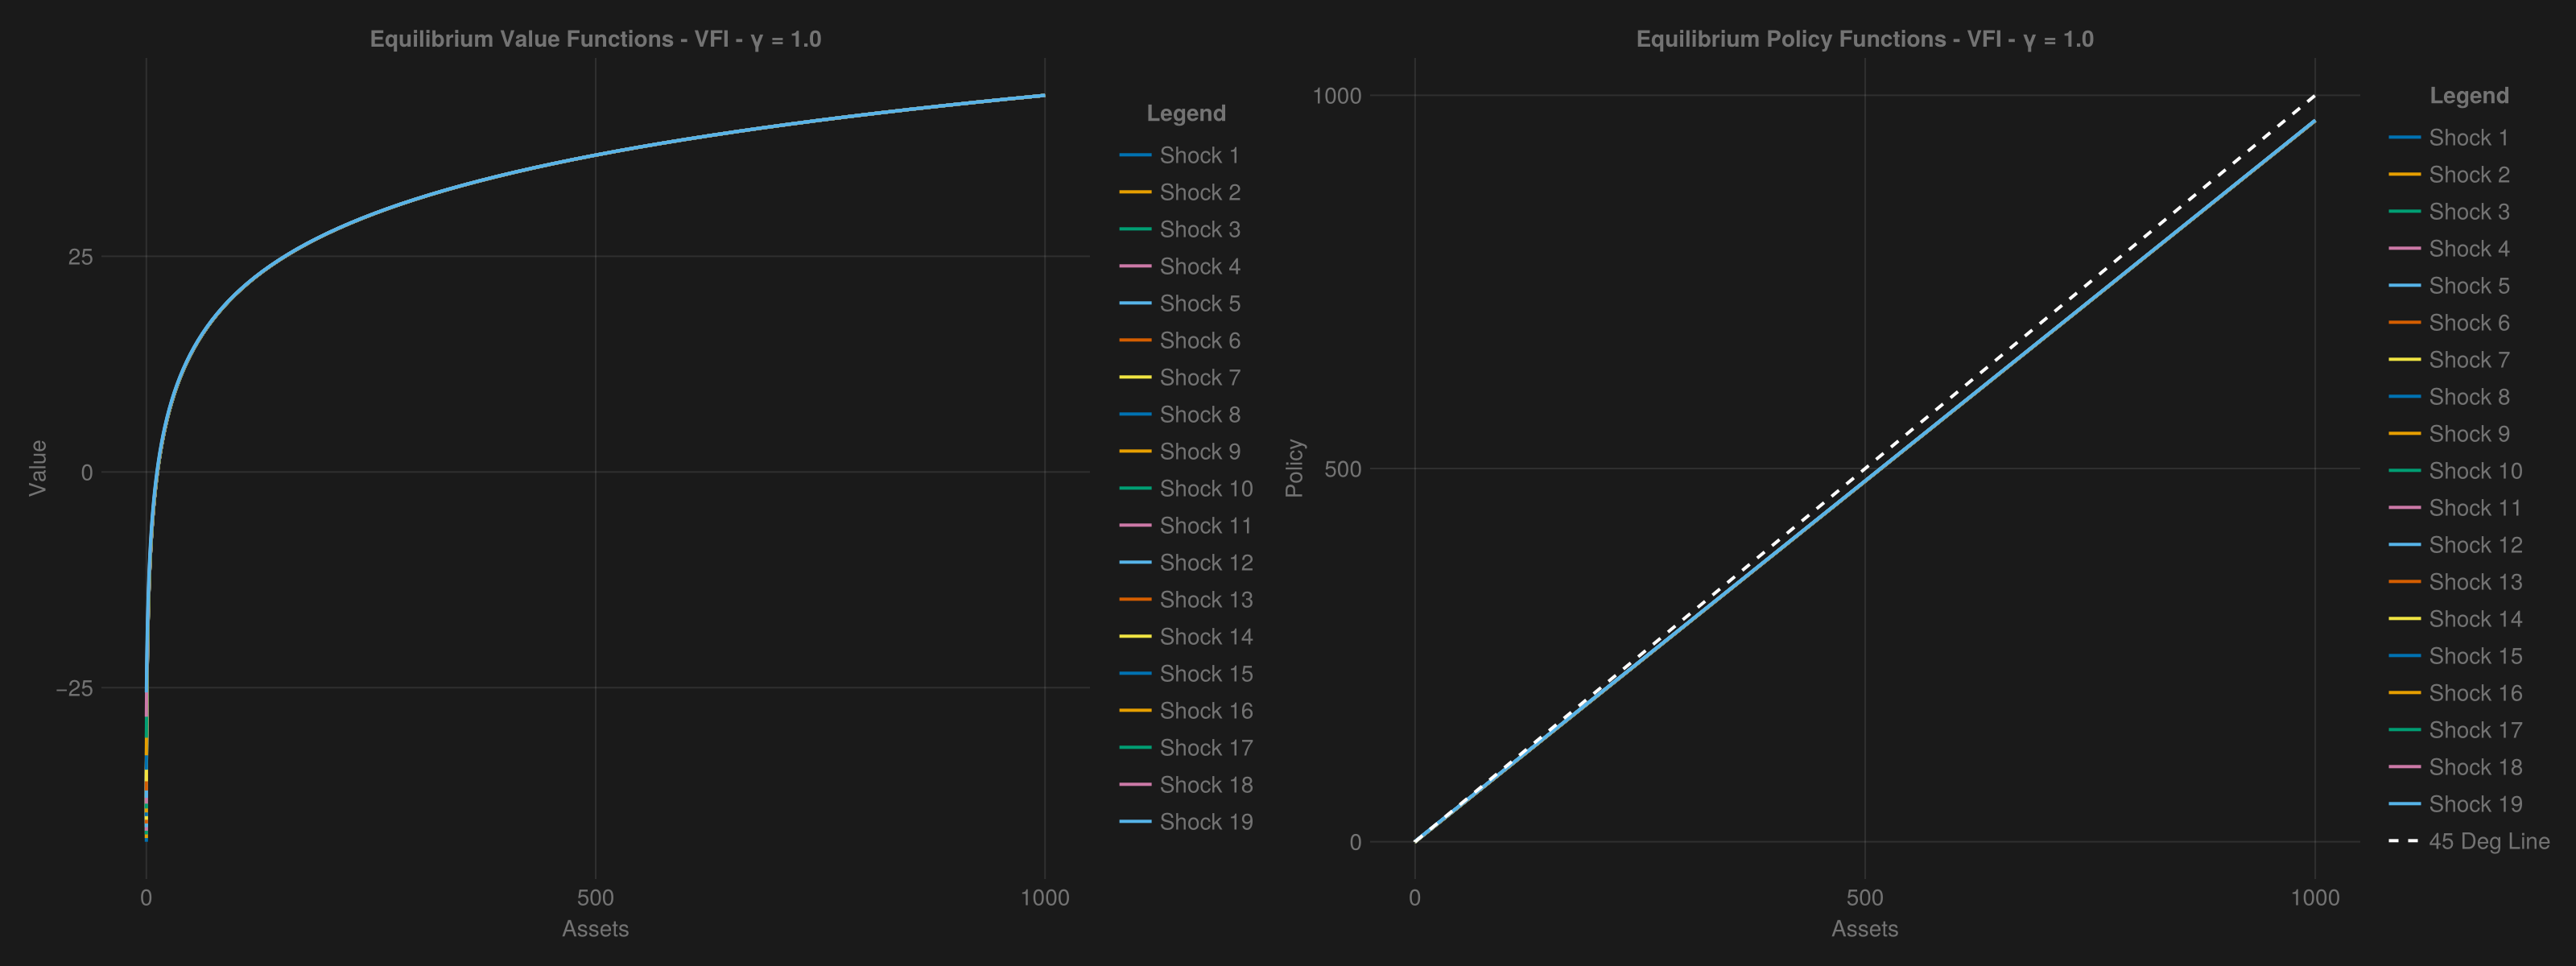

In [10]:
fig1 = Figure(size = (1600, 600))
ax1 = Axis(fig1[1, 1], xlabel = "Assets", ylabel = "Value", title = "Equilibrium Value Functions - VFI - γ = 1.0")
for j in 1:pars_crra1.nz
    lines!(ax1, exp_grid(pars_crra1), v_vfi_crra1[:,j], linewidth = 2, label = "Shock $j")
end
legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical, fontsize = 4)
ax2 = Axis(fig1[1,3], xlabel = "Assets", ylabel = "Policy", title = "Equilibrium Policy Functions - VFI - γ = 1.0")
for j in 1:pars_crra1.nz
    lines!(ax2, exp_grid(pars_crra1), pol_vfi_crra1[:,j], linewidth = 2, label = "Shock $j")
end
lines!(ax2, exp_grid(pars_crra1), exp_grid(pars_crra1), color = :white, linewidth = 2, label = "45 Deg Line", linestyle = :dash)
legend = Legend(fig1[1, 4], ax2, "Legend", orientation = :vertical, fontsize = 4)
fig1

In [27]:
@time begin 
    v_vfi_crra2, pol_vfi_crra2, dist_vfi_crra2, wealth_vfi_crra2 = equilibrium_vfi_crra(pars_crra2)
end

Iterating on prices...
////////////////////
Price Iteration: 0
Iterating...
--------------------
Iteration: 0, Error: 0.9995961252550947
--------------------
Converged in 172 iterations for r = 0.025 and w = 0.018340836716457993
--------------------
%%%%%%%%%%%%%%%%%%%%
Iter = 0, Ks = 0.05972423847114112, Kd = 0.06344642249526665, diff = -0.0037221840241255313
%%%%%%%%%%%%%%%%%%%%
////////////////////
Price Iteration: 1
Iterating...
--------------------
Iteration: 0, Error: 0.030790708462665815
--------------------
Converged in 132 iterations for r = 0.037500000000000006 and w = 0.017672545854601797
--------------------
%%%%%%%%%%%%%%%%%%%%
Iter = 1, Ks = 0.06176300116572068, Kd = 0.05669680308087658, diff = 0.005066198084844098
%%%%%%%%%%%%%%%%%%%%
////////////////////
Price Iteration: 2
Iterating...
--------------------
Iteration: 0, Error: 0.015271800591840119
--------------------
Converged in 126 iterations for r = 0.03125 and w = 0.017994202629576402
--------------------
%%%%%%%%%

([-2999.371698549435 -2127.153342269252 … -192.04547543237382 -152.03243454097202; -2935.4072078005634 -2099.5315427812257 … -192.043591764581 -152.0313082363929; … ; -0.23293865475168762 -0.23293860553380732 … -0.2328125023206849 -0.23274584111357957; -0.22376767619096263 -0.22376763077728729 … -0.22365127216532404 -0.22358976031561245], [3.9314077565577595e-16 3.7220715918606905e-16 … 0.4636347343327767 0.7260549512127287; 4.0340442981818427e-16 3.7859228422596247e-16 … 0.46364421723279625 0.7260644911216333; … ; 925.3749504786608 925.375146198074 … 925.8768783113684 926.142323356613; 963.3327508718223 963.3329465533735 … 963.834582188751 964.0999794363489], [0.0 3.994563607520772e-7 … 4.008440259096919e-7 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0003964017790483064 0.0006058863087654627 … 0.5376254776667938 0.8217418119158013; 0.00040668302904830637 0.0006161675587654626 … 0.5376357589167938 0.8217520931658013; … ; 987.6131691830291 987.6133786675588 … 9

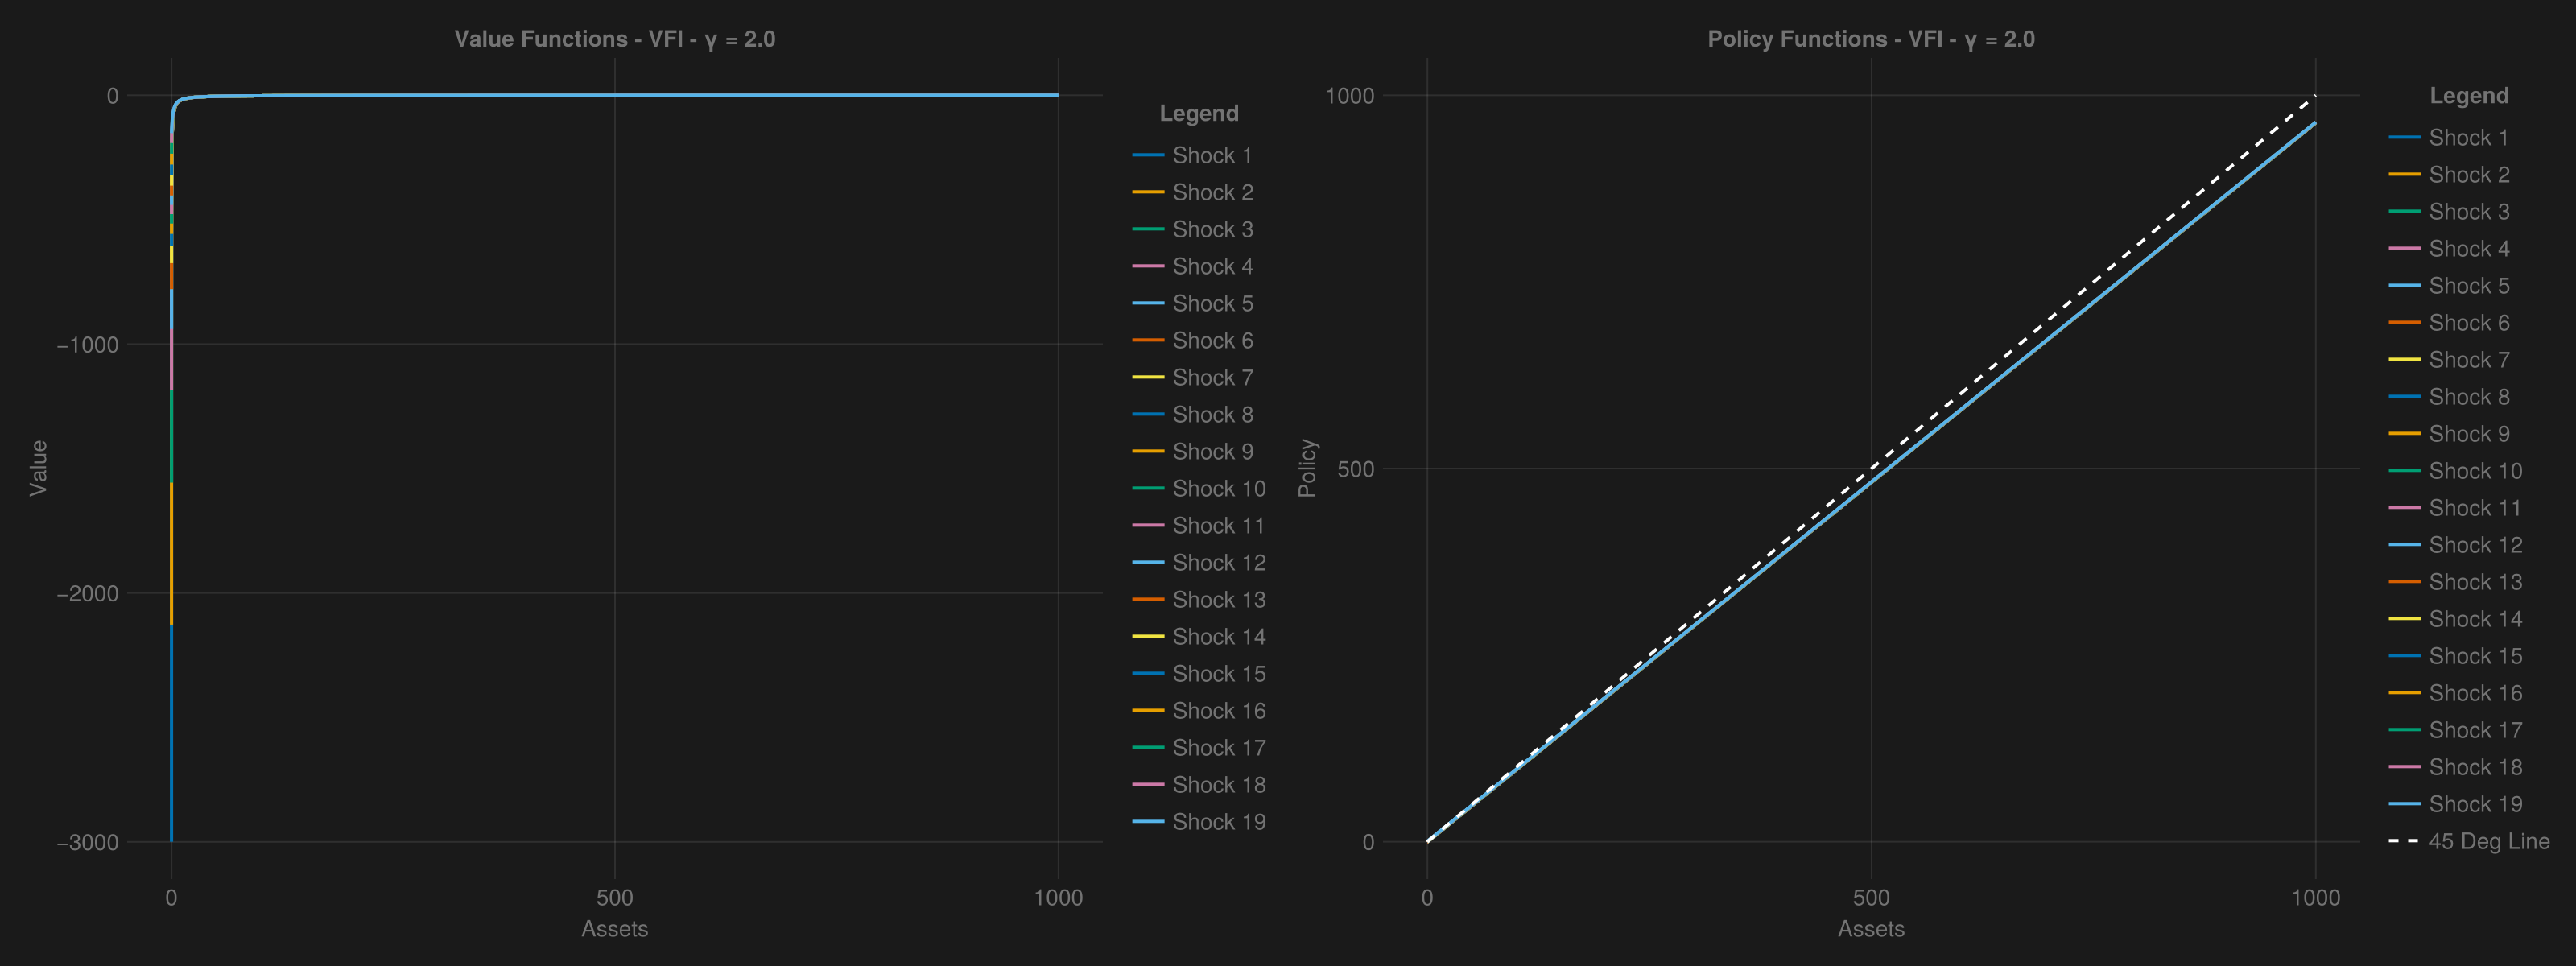

In [28]:
fig2 = Figure(size = (1600, 600))
ax1 = Axis(fig2[1, 1], xlabel = "Assets", ylabel = "Value", title = "Value Functions - VFI - γ = 2.0")
for j in 1:pars_crra2.nz
    lines!(ax1, exp_grid(pars_crra2), v_vfi_crra2[:,j], linewidth = 2, label = "Shock $j")
end
legend = Legend(fig2[1, 2], ax1, "Legend", orientation = :vertical, fontsize = 4)
ax2 = Axis(fig2[1, 3], xlabel = "Assets", ylabel = "Policy", title = "Policy Functions - VFI - γ = 2.0")
for j in 1:pars_crra2.nz
    lines!(ax2, exp_grid(pars_crra2), pol_vfi_crra2[:,j], linewidth = 2, label = "Shock $j")
end
lines!(ax2, exp_grid(pars_crra2), exp_grid(pars_crra2), color = :white, linewidth = 2, label = "45 Deg Line", linestyle = :dash)
legend = Legend(fig2[1, 4], ax2, "Legend", orientation = :vertical, fontsize = 4)
fig2

In [33]:
function equilibrium_hpi_crra(pars)
    (; na, nz, toler_prices, maxiter_prices, print_skip_prices, r_lb, w, β, A, α, ϕ, δ, r_ub) = pars
    n = na * nz
    M = zeros(na, nz, na, nz)
    O = zeros(n, n)
    X = zeros(n+1,n)
    Y = zeros(n+1)
    Inv = zeros(n)
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_init = zeros(na,nz)
    policy = similar(v_init)
    wealth = zeros(na,nz)
    L = labour_supply(Π, Zvals, pars)
    Ks, Kd = 1, 1
    iter = 0
    error = toler_prices + 1
    if iter == 0
        println("Iterating on prices...")
    end
    while ((error > toler_prices) && (iter < maxiter_prices))
        println("////////////////////")
        println("Price Iteration: $iter")
        r_iter = (pars.r_lb + pars.r_ub) / 2
        Kd = ((A^α * L ^ (1-α)) / (r_iter + δ))^1/(1-α)
        w_iter = (1-α) * A * (Kd/L)^α
        Φ = w_iter * (exp(minimum(Zvals))/r_iter)
        if ϕ > 0
            ϕ_iter = min(Φ, exp(minimum(Zvals)))
            pars = (; pars..., ϕ = ϕ_iter, r_iter = r_iter, w = w_iter)
        else
            pars = (; pars..., r_iter = r_iter, w = w_iter)
        end
        v_new, policy = hpi(v_init, policy, Π, Zvals, Avals, pars)
        Invariant = invariant_distribution(M, O, X, Y, Inv, policy, Π, Avals, n, pars)
        G = reshape(policy .- ϕ, n, 1)
        Ks = dot(Invariant', G)
        diff = Ks - Kd
        error = abs(diff)
        if diff > 0
            pars = (; pars..., r_ub = r_iter)
        else
            pars = (; pars..., r_lb = r_iter)
        end
        if iter % print_skip_prices == 0
            println("%%%%%%%%%%%%%%%%%%%%")
            println("Iter = $iter, Ks = $Ks, Kd = $Kd, diff = $diff")
            println("%%%%%%%%%%%%%%%%%%%%")
        end
        v_init .= v_new
        iter += 1
    end
    r_final = (pars.r_lb + pars.r_ub) / 2
    w_final = (1-α) * A * (Kd/L)^α
    Invariant = reshape(Invariant, na, nz)
    for i in 1:na
        for j in 1:nz
            wealth[i,j] = w_final * exp(Zvals[j]) + (1 + r_final) * Avals[i]
        end
    end
    println("%%%%%%%%%%%%%%%%%%%%")
    println("r = $r_final, w = $w_final")
    println("%%%%%%%%%%%%%%%%%%%%")
    return v_init, policy, Invariant, wealth
end

equilibrium_hpi_crra (generic function with 1 method)

In [34]:
@time begin 
    v_hpi_crra1, pol_hpi_crra1, dist_hpi_crra1, wealth_hpi_crra1 = equilibrium_hpi_crra(pars_crra1)
end

Iterating on prices...
////////////////////
Price Iteration: 0
Iterating...
--------------------
Iteration: 0, Error: 0.978010011369693
--------------------
Converged in 7 iterations for r = 0.05 and w = 0.017092685700304328
--------------------
%%%%%%%%%%%%%%%%%%%%
Iter = 0, Ks = 0.039587142054469726, Kd = 0.05124518740002307, diff = -0.011658045345553342
%%%%%%%%%%%%%%%%%%%%
////////////////////
Price Iteration: 1
Iterating...
--------------------
Iteration: 0, Error: 2.064488617828362
--------------------
Converged in 4 iterations for r = 0.07500000000000001 and w = 0.016128803571117394
--------------------
%%%%%%%%%%%%%%%%%%%%
Iter = 1, Ks = 58.364661026156284, Kd = 0.04297983459356773, diff = 58.32168119156272
%%%%%%%%%%%%%%%%%%%%
////////////////////
Price Iteration: 2
Iterating...
--------------------
Iteration: 0, Error: 1.0810159907384629
--------------------
Converged in 4 iterations for r = 0.0625 and w = 0.016582603168472557
--------------------
%%%%%%%%%%%%%%%%%%%%
Iter = 

([-42.862216515262745 -42.43795244655035 … -28.368454425582776 -25.554823697675488; -42.83255032993878 -42.4184440784221 … -28.368316966611687 -25.554721186530738; … ; 43.25706356324836 43.25706538975176 … 43.261746587650734 43.26422234294774; 43.65894923846376 43.65895099296503 … 43.663447695184345 43.665825908756034], [4.362763867170562e-16 4.121256178826648e-16 … 0.40541461524085326 0.6343076968720955; 2.273683234517254e-16 4.202444512618228e-16 … 0.40542422424695373 0.6343173217912538; … ; 927.9939824215862 927.9941519856555 … 928.4288333844972 928.6588053293176; 966.0587369161391 966.0589062423257 … 966.4935495093082 966.7235032334131], [0.0 2.0088553458993318e-6 … 2.0641837468026507e-6 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.00035649808546227215 0.0005448949033509978 … 0.48350553305815297 0.7390213621028735; 0.00036722464796227214 0.0005556214658509978 … 0.483516259620653 0.7390320886653735; … ; 1030.389670349648 1030.389858746466 … 1030.872819384620

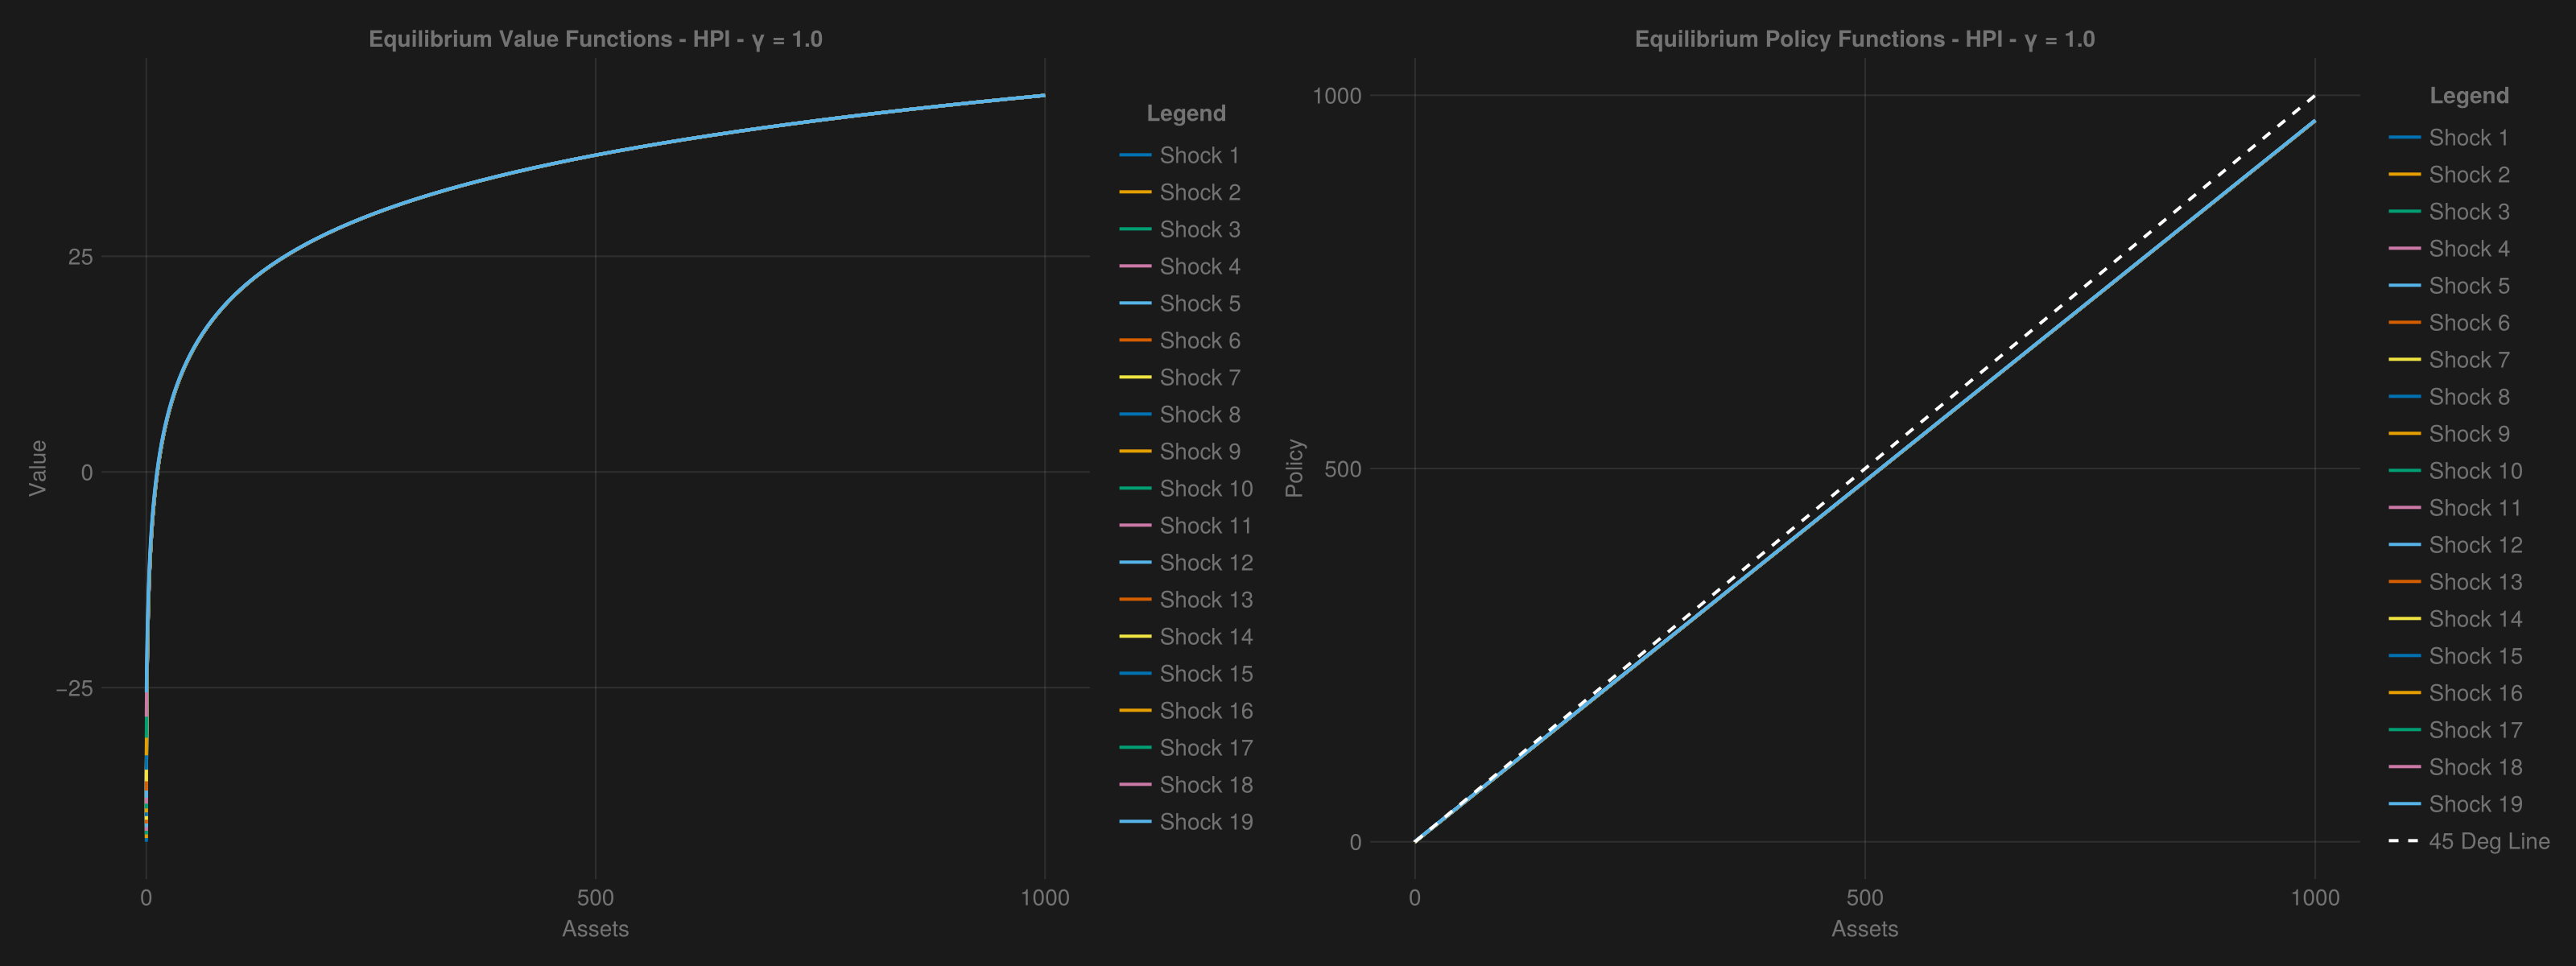

In [38]:
fig3 = Figure(size = (1600, 600))
ax1 = Axis(fig3[1, 1], xlabel = "Assets", ylabel = "Value", title = "Equilibrium Value Functions - HPI - γ = 1.0")
for j in 1:pars_crra1.nz
    lines!(ax1, exp_grid(pars_crra1), v_hpi_crra1[:,j], linewidth = 2, label = "Shock $j")
end
legend = Legend(fig3[1, 2], ax1, "Legend", orientation = :vertical, fontsize = 4)
ax2 = Axis(fig3[1, 3], xlabel = "Assets", ylabel = "Policy", title = "Equilibrium Policy Functions - HPI - γ = 1.0")
for j in 1:pars_crra1.nz
    lines!(ax2, exp_grid(pars_crra1), pol_hpi_crra1[:,j], linewidth = 2, label = "Shock $j")
end
lines!(ax2, exp_grid(pars_crra1), exp_grid(pars_crra1), color = :white, linewidth = 2, label = "45 Deg Line", linestyle = :dash)
legend = Legend(fig3[1, 4], ax2, "Legend", orientation = :vertical, fontsize = 4)
fig3

In [37]:
@time begin 
    v_hpi_crra2, pol_hpi_crra2, dist_hpi_crra2, wealth_hpi_crra2 = equilibrium_hpi_crra(pars_crra2)
end

Iterating on prices...
////////////////////
Price Iteration: 0
Iterating...
--------------------
Iteration: 0, Error: 0.9996874109540861
--------------------
Converged in 8 iterations for r = 0.025 and w = 0.018340836716457993
--------------------
%%%%%%%%%%%%%%%%%%%%
Iter = 0, Ks = 0.05972423840796668, Kd = 0.06344642249526665, diff = -0.0037221840872999692
%%%%%%%%%%%%%%%%%%%%
////////////////////
Price Iteration: 1
Iterating...
--------------------
Iteration: 0, Error: 0.15691077348514806
--------------------
Converged in 5 iterations for r = 0.037500000000000006 and w = 0.017672545854601797
--------------------
%%%%%%%%%%%%%%%%%%%%
Iter = 1, Ks = 0.061763002189439226, Kd = 0.05669680308087658, diff = 0.005066199108562645
%%%%%%%%%%%%%%%%%%%%
////////////////////
Price Iteration: 2
Iterating...
--------------------
Iteration: 0, Error: 0.07143989384962245
--------------------
Converged in 5 iterations for r = 0.03125 and w = 0.017994202629576402
--------------------
%%%%%%%%%%%%%%%%

([-2999.3716947790963 -2127.153338498913 … -192.04547166189755 -152.03243077049788; -2935.407204030225 -2099.531539010887 … -192.04358799410477 -152.03130446591874; … ; -0.2329418501331888 -0.23294180091475697 … -0.23281569626768175 -0.23274903431345342; -0.22377076801444035 -0.223770722600248 … -0.22365436264575145 -0.22359285009579197], [3.9314077565577457e-16 3.7220715918606925e-16 … 0.4636347343355569 0.726054951213582; 4.0340442981818496e-16 3.7859228422596143e-16 … 0.46364421723294524 0.7260644911218189; … ; 925.3753168762536 925.37551259649 … 925.8772449814322 926.142690170964; 963.3331381434601 963.3333338241164 … 963.8349697374101 964.1003671340378], [0.0 3.9945657521084643e-7 … 4.008442370499719e-7 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0003964017790483064 0.0006058863087654627 … 0.5376254776667938 0.8217418119158013; 0.00040668302904830637 0.0006161675587654626 … 0.5376357589167938 0.8217520931658013; … ; 987.6131691830291 987.6133786675588 … 9

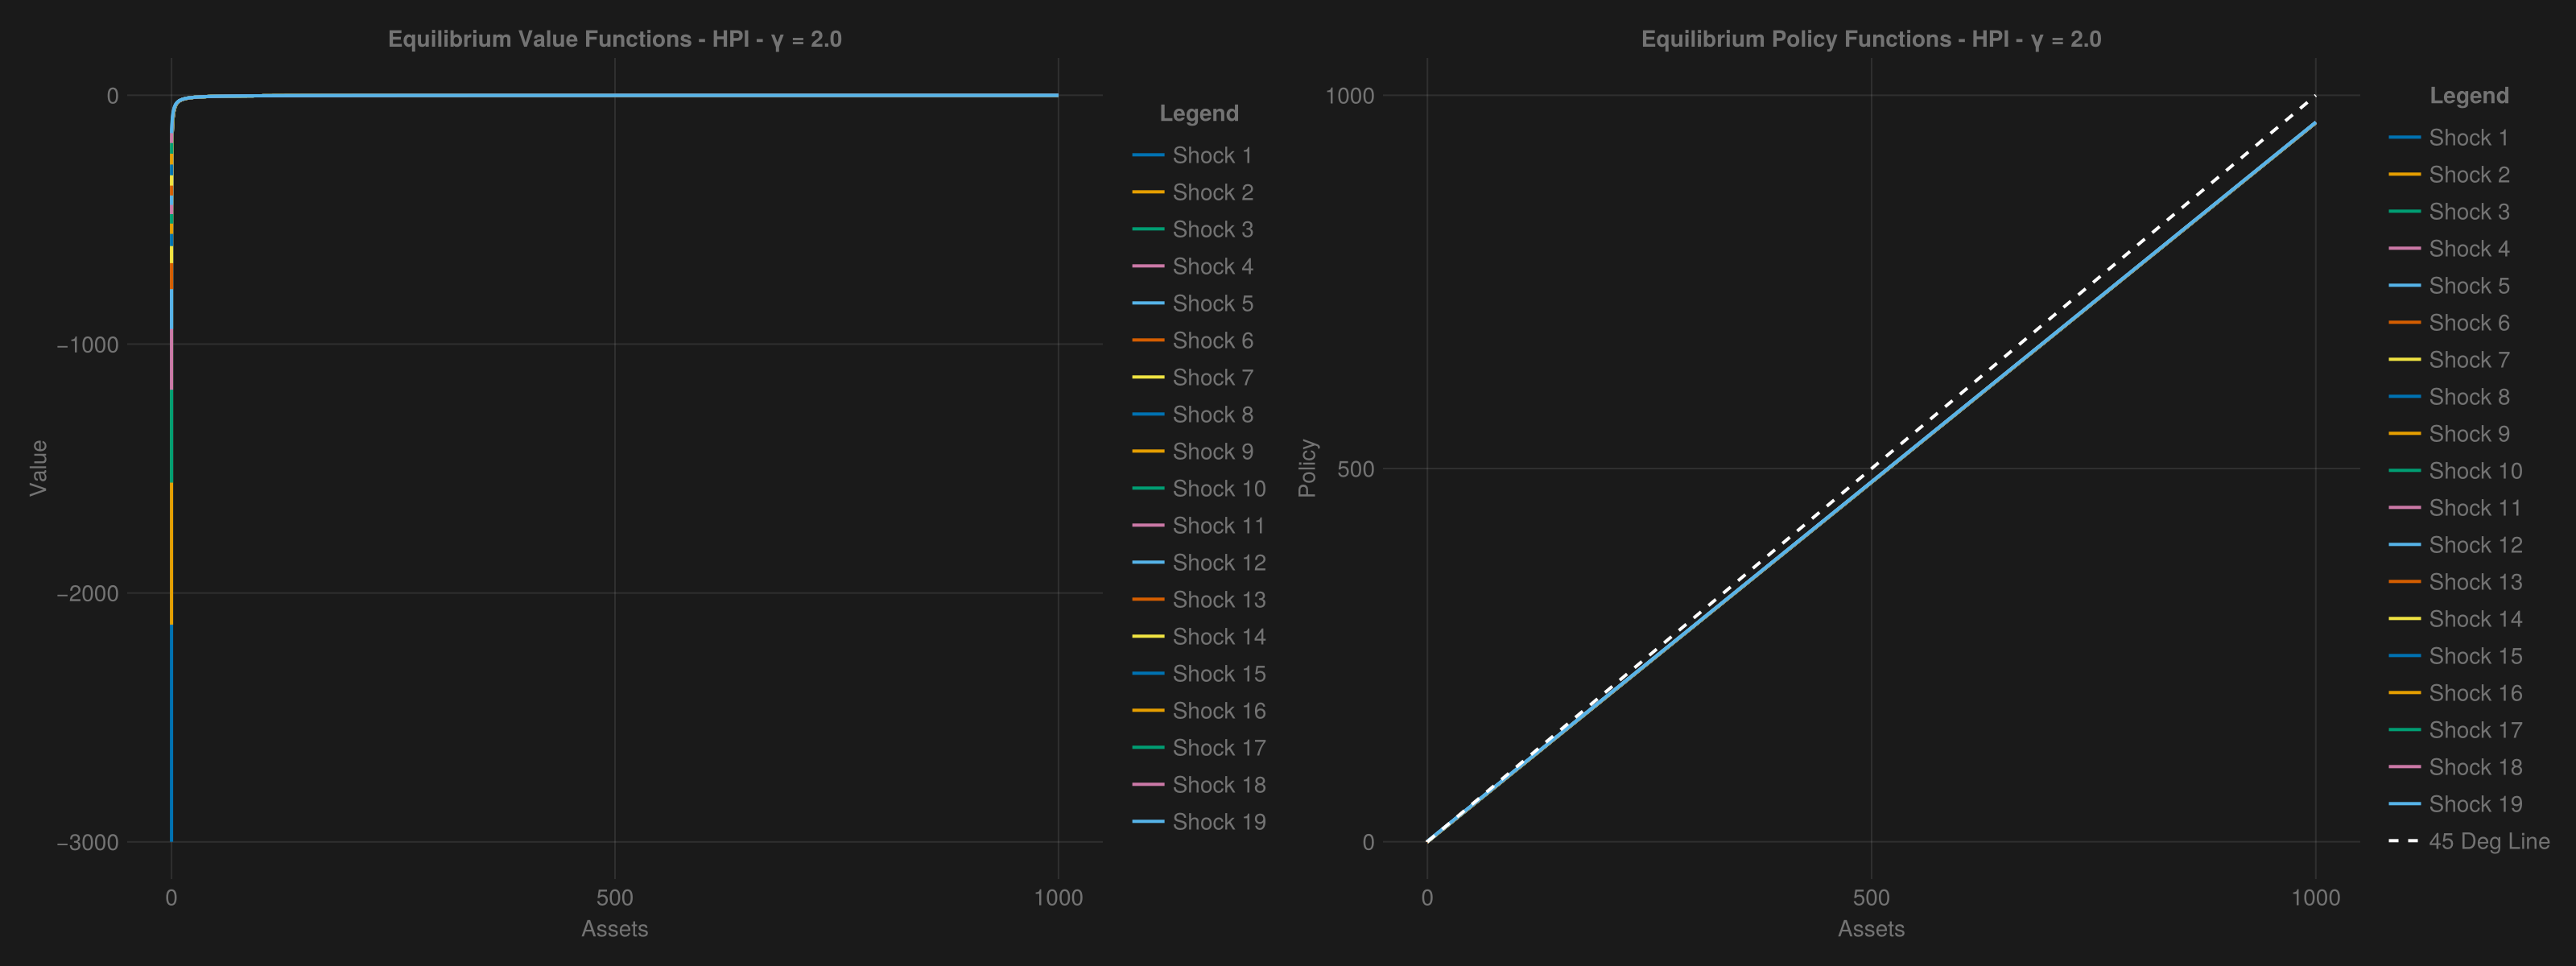

In [58]:
fig4 = Figure(size = (1600, 600))
ax1 = Axis(fig4[1, 1], xlabel = "Assets", ylabel = "Value", title = "Equilibrium Value Functions - HPI - γ = 2.0")
for j in 1:pars_crra2.nz
    lines!(ax1, exp_grid(pars_crra2), v_hpi_crra2[:,j], linewidth = 2, label = "Shock $j")
end
legend = Legend(fig4[1, 2], ax1, "Legend", orientation = :vertical, fontsize = 4)
ax2 = Axis(fig4[1, 3], xlabel = "Assets", ylabel = "Policy", title = "Equilibrium Policy Functions - HPI - γ = 2.0")
for j in 1:pars_crra2.nz
    lines!(ax2, exp_grid(pars_crra2), pol_hpi_crra2[:,j], linewidth = 2, label = "Shock $j")
end
lines!(ax2, exp_grid(pars_crra2), exp_grid(pars_crra2), color = :white, linewidth = 2, label = "45 Deg Line", linestyle = :dash)
legend = Legend(fig4[1, 4], ax2, "Legend", orientation = :vertical, fontsize = 4)
fig4

In [129]:
pars_ces2 = (;A = 0.01, # total factor productivity
    α = 0.33, # capital share
    δ = 0.08, # depreciation rate
    r_lb = 0.0, # lower bound on interest rate
    r_ub = 0.2, # upper bound on interest rate
    r_iter = 0.0, # interest rate during iteration
    w = 1.0, # wage
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion (recall that this must be greater than 1 in the CES formulation)
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 101, # number of asset grid points
    ϕ = 0.0, # borrowing constraint
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    max_iter = 1000, # maximum no. of iterations
    print_skip = 1000, # how often to print
    how_iter = 0, # number of Howard iterations
    dampened_howard = true, # whether to dampen Howard improvement step
    ϵ = 0.1, # factor by which to dampen Howard improvement step
    toler_prices = 1e-3, # tolerance
    maxiter_prices = 100, # maximum no. of iterations
    print_skip_prices = 1, # how often to print
    lb = 0.0, # lower bound of capital grid
    ub = 10_000.0) # upper bound of capital grid

(A = 0.01, α = 0.33, δ = 0.08, r_lb = 0.0, r_ub = 0.2, r_iter = 0.0, w = 1.0, β = 0.9, γ = 2.0, nz = 19, ρ = 0.9, μ = 0.0, σ = 0.003, na = 101, ϕ = 0.0, θ = 4.0, toler = 4.0e-7, max_iter = 1000, print_skip = 1000, how_iter = 0, dampened_howard = true, ϵ = 0.1, toler_prices = 0.001, maxiter_prices = 100, print_skip_prices = 1, lb = 0.0, ub = 10000.0)

In [130]:
function equilibrium_vfi_CES(pars)
    (; na, nz, toler_prices, maxiter_prices, print_skip_prices, r_lb, w, β, A, α, ϕ, δ, r_ub) = pars
    n = na * nz
    M = zeros(na, nz, na, nz)
    O = zeros(n, n)
    X = zeros(n+1,n)
    Y = zeros(n+1)
    Inv = zeros(n)
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_init = zeros(na,nz)
    for j in 1:nz
        v_init[:,j] = Avals .^ (1-α)
    end
    policy = similar(v_init)
    wealth = zeros(na,nz)
    L = labour_supply(Π, Zvals, pars)
    Ks, Kd = 1, 1
    iter = 0
    error = toler_prices + 1
    if iter == 0
        println("Iterating on prices...")
    end
    while ((error > toler_prices) && (iter < maxiter_prices))
        println("////////////////////")
        println("Price Iteration: $iter")
        r_iter = (pars.r_lb + pars.r_ub) / 2
        Kd = ((A^α * L ^ (1-α)) / (r_iter + δ))^1/(1-α)
        w_iter = (1-α) * A * (Kd/L)^α
        Φ = w_iter * (exp(minimum(Zvals))/r_iter)
        if ϕ > 0
            ϕ_iter = min(Φ, ϕ)
            pars = (; pars..., ϕ = ϕ_iter, r_iter = r_iter, w = w_iter)
        else
            pars = (; pars..., r_iter = r_iter, w = w_iter)
        end
        v_new, policy = vfi_CES(v_init, policy, Π, Zvals, Avals, pars)
        Invariant = invariant_distribution(M, O, X, Y, Inv, policy, Π, Avals, n, pars)
        G = reshape(policy .- ϕ, n, 1)
        Ks = dot(Invariant', G)
        diff = Ks - Kd
        error = abs(diff)
        if diff > 0
            pars = (; pars..., r_ub = r_iter)
        else
            pars = (; pars..., r_lb = r_iter)
        end
        if iter % print_skip_prices == 0
            println("%%%%%%%%%%%%%%%%%%%%")
            println("Iter = $iter, Ks = $Ks, Kd = $Kd, diff = $diff")
            println("%%%%%%%%%%%%%%%%%%%%")
        end
        v_init .= v_new
        iter += 1
    end
    r_final = (pars.r_lb + pars.r_ub) / 2
    w_final = (1-α) * A * (Kd/L)^α
    Invariant = reshape(Invariant, na, nz)
    for i in 1:na
        for j in 1:nz
            wealth[i,j] = w_final * exp(Zvals[j]) + (1 + r_final) * Avals[i]
        end
    end
    println("%%%%%%%%%%%%%%%%%%%%")
    println("r = $r_final, w = $w_final")
    println("%%%%%%%%%%%%%%%%%%%%")
    return v_init, policy, Invariant, wealth
end

equilibrium_vfi_CES (generic function with 1 method)

In [131]:
@time begin 
    v_vfi_ces2, pol_vfi_ces2, dist_vfi_ces2, wealth_vfi_ces2 = equilibrium_vfi_CES(pars_ces2)
end

Iterating on prices...
////////////////////
Price Iteration: 0
Iterating...
--------------------
Iteration: 0, Error: 0.3410538334232484
--------------------
Converged in 123 iterations
--------------------
%%%%%%%%%%%%%%%%%%%%
Iter = 0, Ks = 0.2465050379592116, Kd = 0.037010413122238885, diff = 0.20949462483697273
%%%%%%%%%%%%%%%%%%%%
////////////////////
Price Iteration: 1
Iterating...
--------------------
Iteration: 0, Error: 0.04756786904951638
--------------------
Converged in 149 iterations
--------------------
%%%%%%%%%%%%%%%%%%%%
Iter = 1, Ks = 0.062936398493546, Kd = 0.05124518740002307, diff = 0.011691211093522932
%%%%%%%%%%%%%%%%%%%%
////////////////////
Price Iteration: 2
Iterating...
--------------------
Iteration: 0, Error: 0.02434623388521494
--------------------
Converged in 167 iterations
--------------------
%%%%%%%%%%%%%%%%%%%%
Iter = 2, Ks = 0.05080730062511332, Kd = 0.06344642249526665, diff = -0.012639121870153328
%%%%%%%%%%%%%%%%%%%%
////////////////////
Price It

([0.0033288910455350016 0.004726099265575935 … 0.05284781972796629 0.06700258891975473; 0.004059229661633982 0.005357885665539193 … 0.05285311886454338 0.06700772161228688; … ; 469.30041532016196 469.30042500761596 … 469.3252590733137 469.33839781876026; 488.5499169879424 488.54992667539636 … 488.57476074107643 488.58789948651344], [2.543936274565197e-16 2.2801963618759565e-16 … 0.45406845272160085 0.7117921666766799; 3.729252637310132e-16 3.0648987320987054e-16 … 0.45416478792789045 0.711888619302401; … ; 9282.263991083097 9282.264182721807 … 9282.755411640015 9283.015301886773; 9663.02773939811 9663.02793101358 … 9663.519159949123 9663.779050201689], [0.0 2.2405899182656573e-6 … 2.1724991372968987e-6 0.0; 0.0 1.6868417922510293e-6 … 1.618989224774875e-6 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.00038931586807644156 0.0005950557407158154 … 0.5280151114366035 0.807052701955009; 0.0004936908680764415 0.0006994307407158154 … 0.5281194864366036 0.807157076955009; … ; 10026.221243

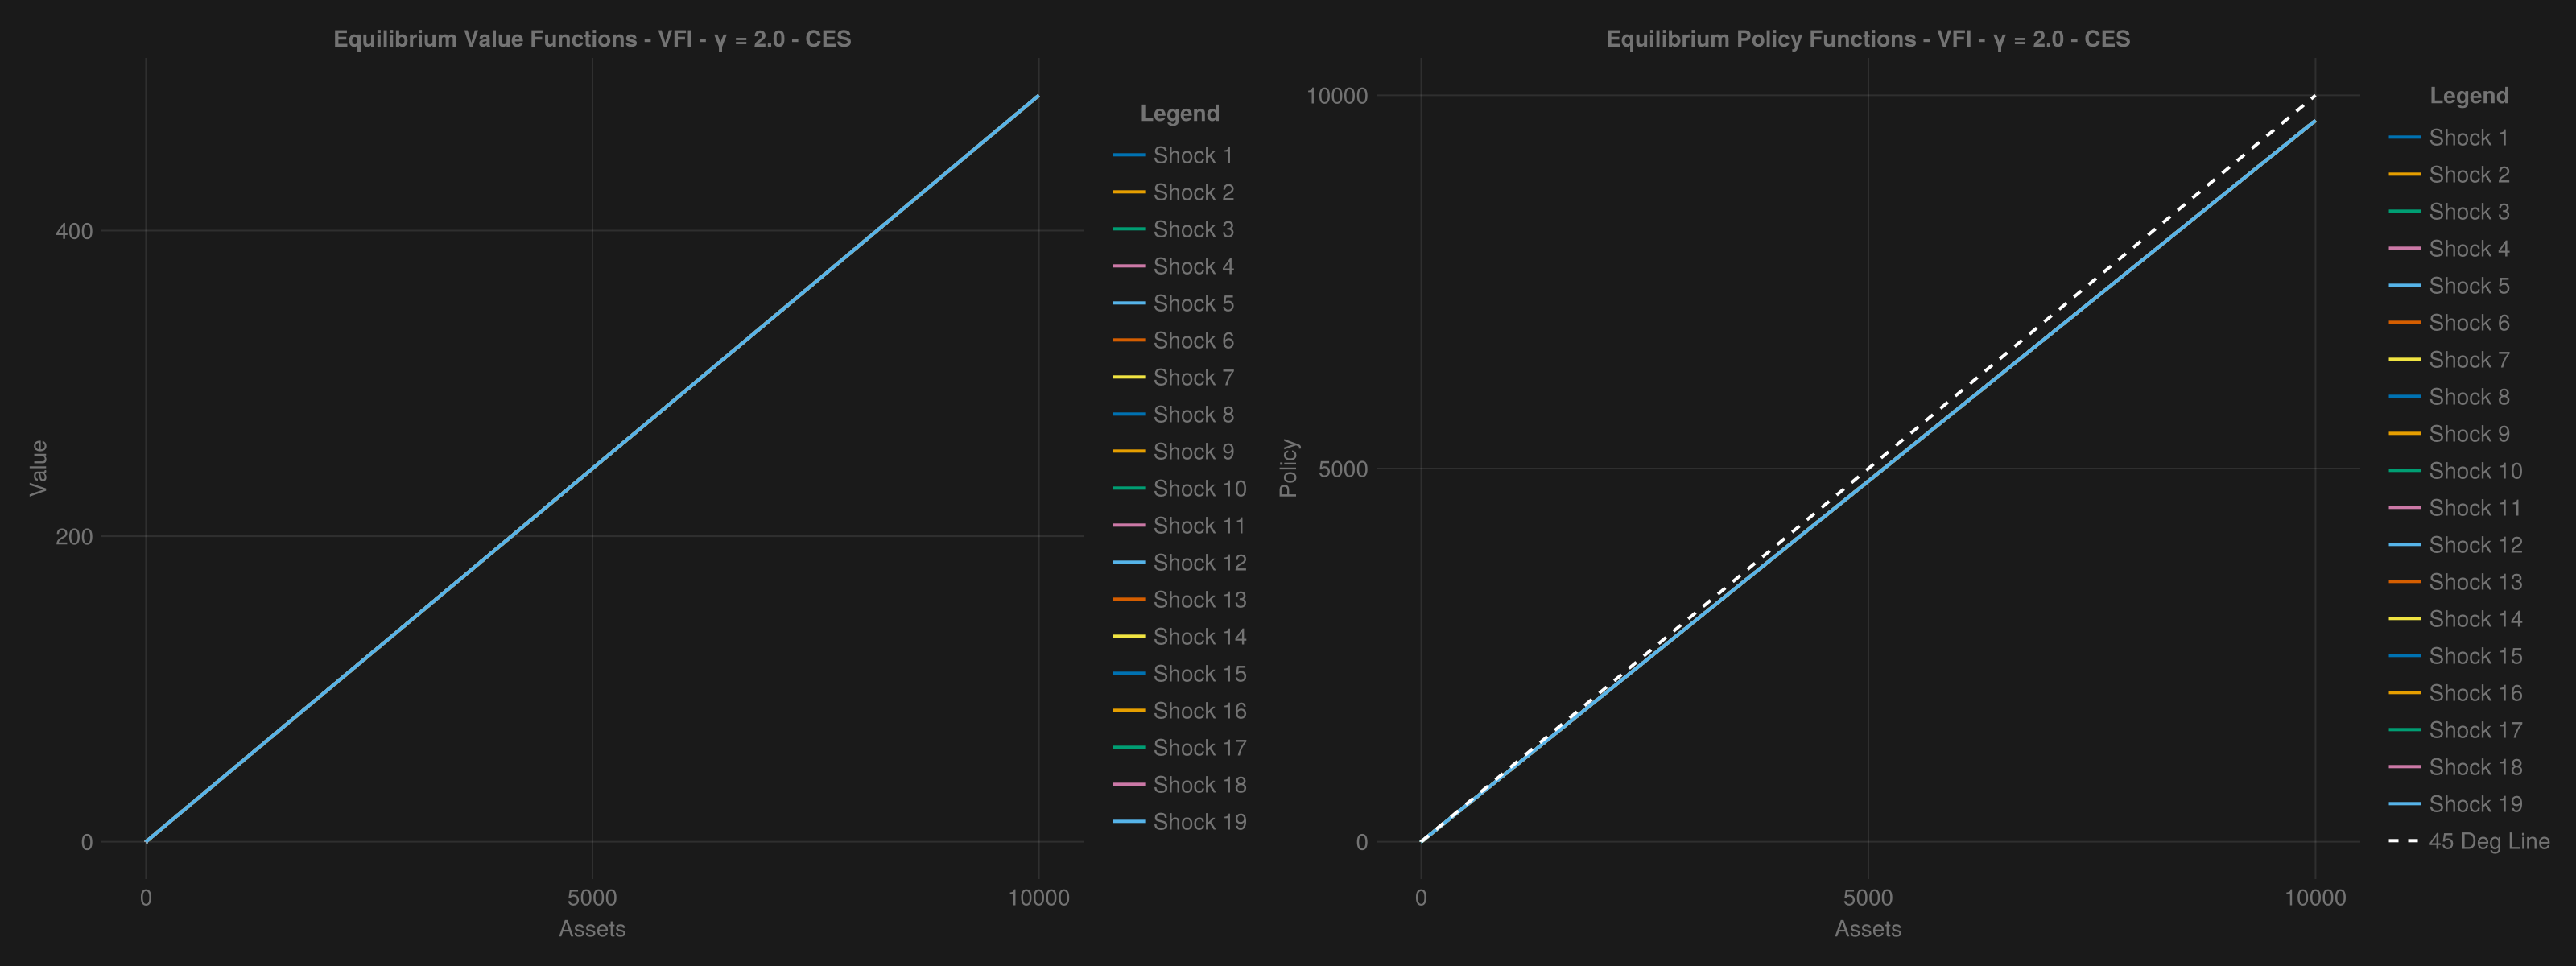

In [132]:
fig5 = Figure(size = (1600, 600))
ax1 = Axis(fig5[1, 1], xlabel = "Assets", ylabel = "Value", title = "Equilibrium Value Functions - VFI - γ = 2.0 - CES")
for j in 1:pars_ces2.nz
    lines!(ax1, exp_grid(pars_ces2), v_vfi_ces2[:,j], linewidth = 2, label = "Shock $j")
end
legend = Legend(fig5[1, 2], ax1, "Legend", orientation = :vertical, fontsize = 4)
ax2 = Axis(fig5[1, 3], xlabel = "Assets", ylabel = "Policy", title = "Equilibrium Policy Functions - VFI - γ = 2.0 - CES")
for j in 1:pars_ces2.nz
    lines!(ax2, exp_grid(pars_ces2), pol_vfi_ces2[:,j], linewidth = 2, label = "Shock $j")
end
lines!(ax2, exp_grid(pars_ces2), exp_grid(pars_ces2), color = :white, linewidth = 2, label = "45 Deg Line", linestyle = :dash)
legend = Legend(fig5[1, 4], ax2, "Legend", orientation = :vertical, fontsize = 4)
fig5

In [133]:
function equilibrium_hpi_CES(pars)
    (; na, nz, toler_prices, maxiter_prices, print_skip_prices, r_lb, w, β, A, α, ϕ, δ, r_ub) = pars
    n = na * nz
    M = zeros(na, nz, na, nz)
    O = zeros(n, n)
    X = zeros(n+1,n)
    Y = zeros(n+1)
    Inv = zeros(n)
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_init = zeros(na,nz)
    for j in 1:nz
        v_init[:,j] = Avals .^ (1-α)
    end
    policy = similar(v_init)
    wealth = zeros(na,nz)
    L = labour_supply(Π, Zvals, pars)
    Ks, Kd = 1, 1
    iter = 0
    error = toler_prices + 1
    if iter == 0
        println("Iterating on prices...")
    end
    while ((error > toler_prices) && (iter < maxiter_prices))
        println("////////////////////")
        println("Price Iteration: $iter")
        r_iter = (pars.r_lb + pars.r_ub) / 2
        Kd = ((A^α * L ^ (1-α)) / (r_iter + δ))^1/(1-α)
        w_iter = (1-α) * A * (Kd/L)^α
        Φ = w_iter * (exp(minimum(Zvals))/r_iter)
        if ϕ > 0
            ϕ_iter = min(Φ, exp(minimum(Zvals)))
            pars = (; pars..., ϕ = ϕ_iter, r_iter = r_iter, w = w_iter)
        else
            pars = (; pars..., r_iter = r_iter, w = w_iter)
        end
        v_new, policy = hpi_CES(v_init, policy, Π, Zvals, Avals, pars)
        Invariant = invariant_distribution(M, O, X, Y, Inv, policy, Π, Avals, n, pars)
        G = reshape(policy .- ϕ, n, 1)
        Ks = dot(Invariant', G)
        diff = Ks - Kd
        error = abs(diff)
        if diff > 0
            pars = (; pars..., r_ub = r_iter)
        else
            pars = (; pars..., r_lb = r_iter)
        end
        if iter % print_skip_prices == 0
            println("%%%%%%%%%%%%%%%%%%%%")
            println("Iter = $iter, Ks = $Ks, Kd = $Kd, diff = $diff")
            println("%%%%%%%%%%%%%%%%%%%%")
        end
        v_init .= v_new
        iter += 1
    end
    r_final = (pars.r_lb + pars.r_ub) / 2
    w_final = (1-α) * A * (Kd/L)^α
    Invariant = reshape(Invariant, na, nz)
    for i in 1:na
        for j in 1:nz
            wealth[i,j] = w_final * exp(Zvals[j]) + (1 + r_final) * Avals[i]
        end
    end
    println("%%%%%%%%%%%%%%%%%%%%")
    println("r = $r_final, w = $w_final")
    println("%%%%%%%%%%%%%%%%%%%%")
    return v_init, policy, Invariant, wealth
end

equilibrium_hpi_CES (generic function with 1 method)

In [134]:
@time begin 
    v_hpi_ces2, pol_hpi_ces2, dist_hpi_ces2, wealth_hpi_ces2 = equilibrium_hpi_CES(pars_ces2)
end

Iterating on prices...
////////////////////
Price Iteration: 0
Iterating...
--------------------
Iteration: 0, Error: 0.3410538334232484
--------------------
Converged in 123 iterations
--------------------
%%%%%%%%%%%%%%%%%%%%
Iter = 0, Ks = 0.2465050379592116, Kd = 0.037010413122238885, diff = 0.20949462483697273
%%%%%%%%%%%%%%%%%%%%
////////////////////
Price Iteration: 1
Iterating...
--------------------
Iteration: 0, Error: 0.04756786904951638
--------------------
Converged in 149 iterations
--------------------
%%%%%%%%%%%%%%%%%%%%
Iter = 1, Ks = 0.062936398493546, Kd = 0.05124518740002307, diff = 0.011691211093522932
%%%%%%%%%%%%%%%%%%%%
////////////////////
Price Iteration: 2
Iterating...
--------------------
Iteration: 0, Error: 0.02434623388521494
--------------------
Converged in 167 iterations
--------------------
%%%%%%%%%%%%%%%%%%%%
Iter = 2, Ks = 0.05080730062511332, Kd = 0.06344642249526665, diff = -0.012639121870153328
%%%%%%%%%%%%%%%%%%%%
////////////////////
Price It

([0.0033288910455350016 0.004726099265575935 … 0.05284781972796629 0.06700258891975473; 0.004059229661633982 0.005357885665539193 … 0.05285311886454338 0.06700772161228688; … ; 469.30041532016196 469.30042500761596 … 469.3252590733137 469.33839781876026; 488.5499169879424 488.54992667539636 … 488.57476074107643 488.58789948651344], [2.543936274565197e-16 2.2801963618759565e-16 … 0.45406845272160085 0.7117921666766799; 3.729252637310132e-16 3.0648987320987054e-16 … 0.45416478792789045 0.711888619302401; … ; 9282.263991083097 9282.264182721807 … 9282.755411640015 9283.015301886773; 9663.02773939811 9663.02793101358 … 9663.519159949123 9663.779050201689], [0.0 2.2405899182656573e-6 … 2.1724991372968987e-6 0.0; 0.0 1.6868417922510293e-6 … 1.618989224774875e-6 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.00038931586807644156 0.0005950557407158154 … 0.5280151114366035 0.807052701955009; 0.0004936908680764415 0.0006994307407158154 … 0.5281194864366036 0.807157076955009; … ; 10026.221243

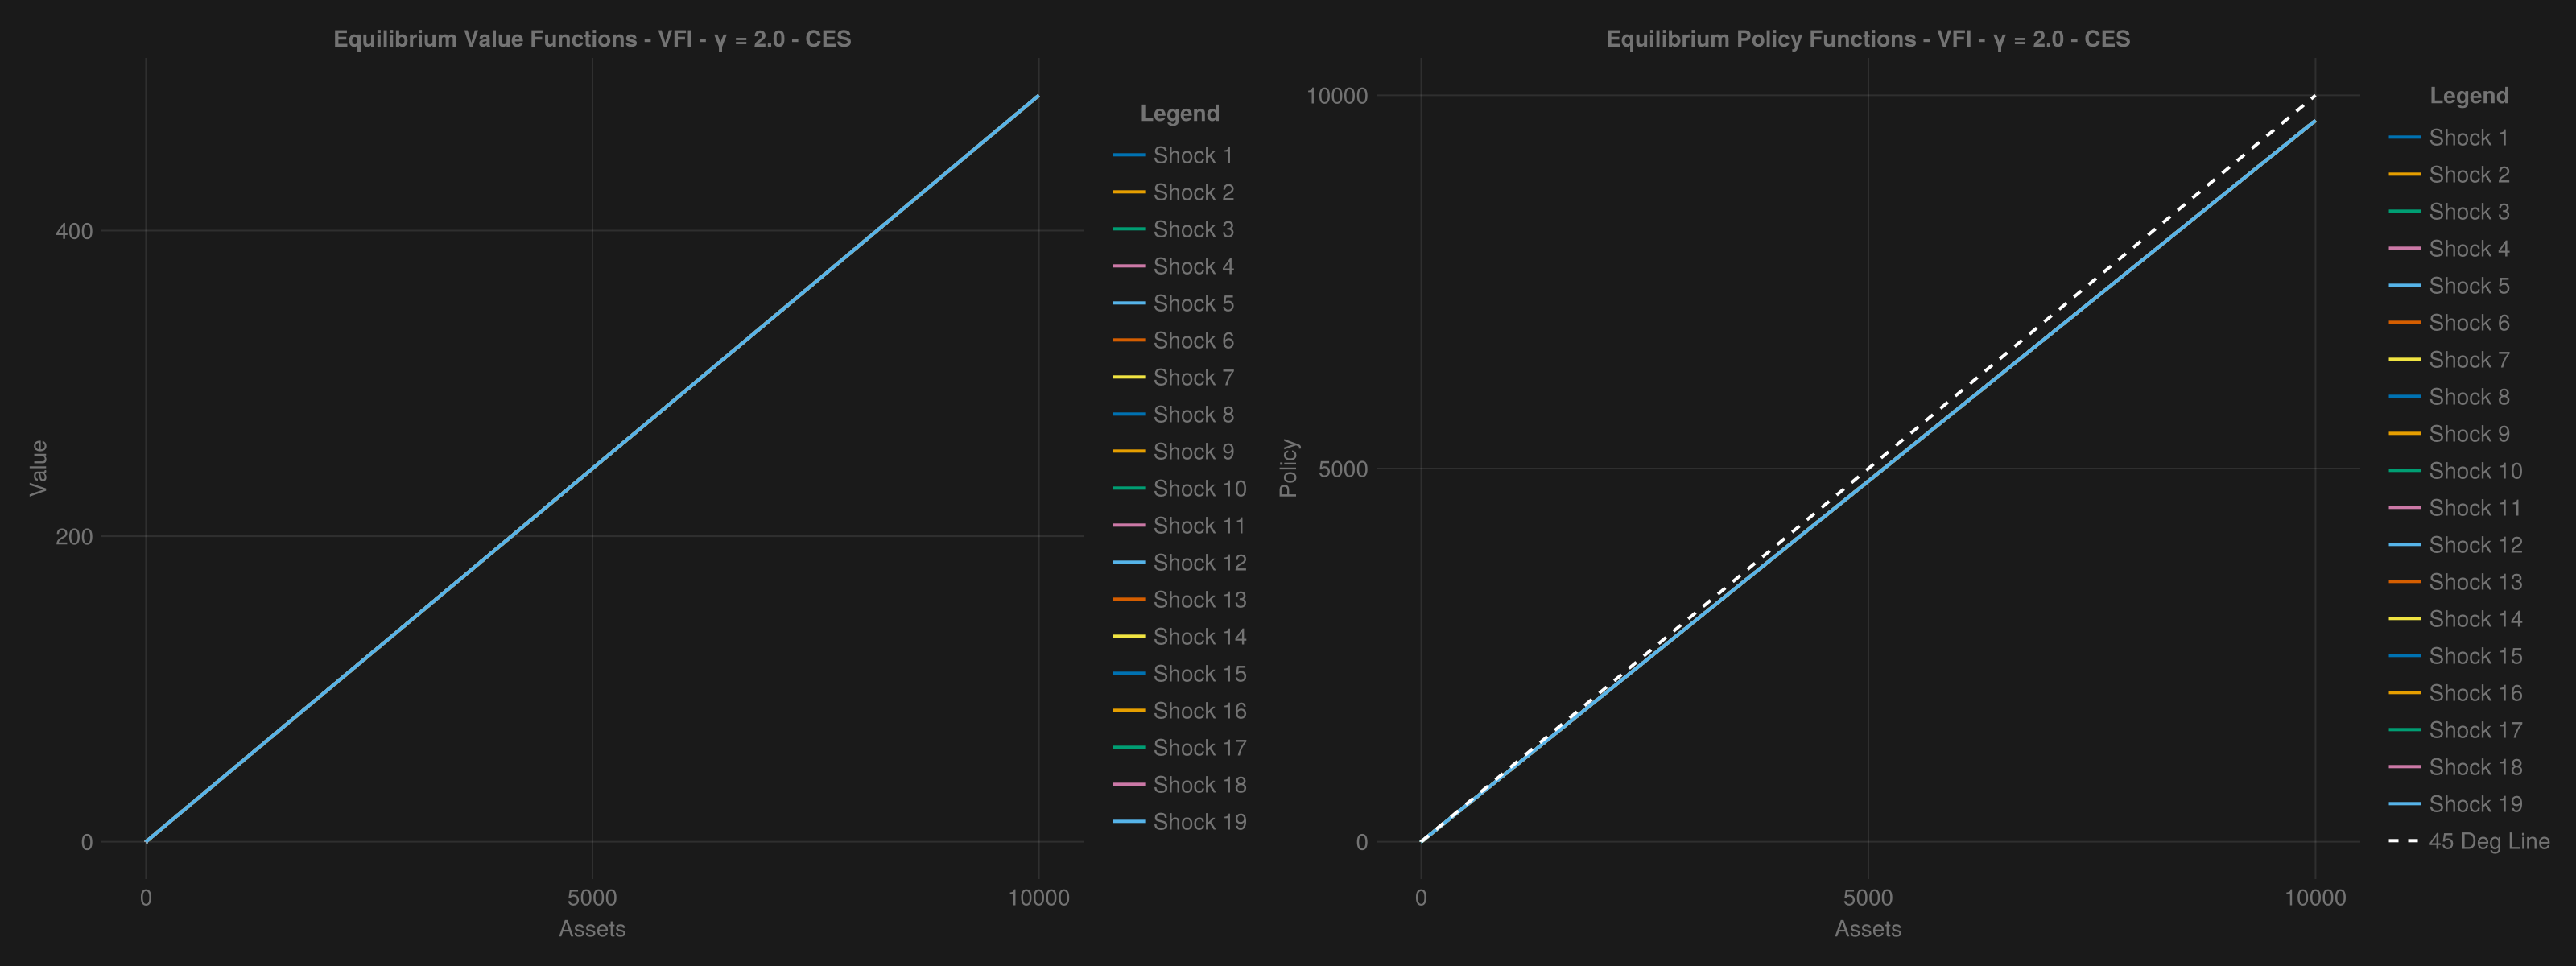

In [135]:
fig6 = Figure(size = (1600, 600))
ax1 = Axis(fig6[1, 1], xlabel = "Assets", ylabel = "Value", title = "Equilibrium Value Functions - VFI - γ = 2.0 - CES")
for j in 1:pars_ces2.nz
    lines!(ax1, exp_grid(pars_ces2), v_hpi_ces2[:,j], linewidth = 2, label = "Shock $j")
end
legend = Legend(fig6[1, 2], ax1, "Legend", orientation = :vertical, fontsize = 4)
ax2 = Axis(fig6[1, 3], xlabel = "Assets", ylabel = "Policy", title = "Equilibrium Policy Functions - VFI - γ = 2.0 - CES")
for j in 1:pars_ces2.nz
    lines!(ax2, exp_grid(pars_ces2), pol_hpi_ces2[:,j], linewidth = 2, label = "Shock $j")
end
lines!(ax2, exp_grid(pars_ces2), exp_grid(pars_ces2), color = :white, linewidth = 2, label = "45 Deg Line", linestyle = :dash)
legend = Legend(fig6[1, 4], ax2, "Legend", orientation = :vertical, fontsize = 4)
fig6

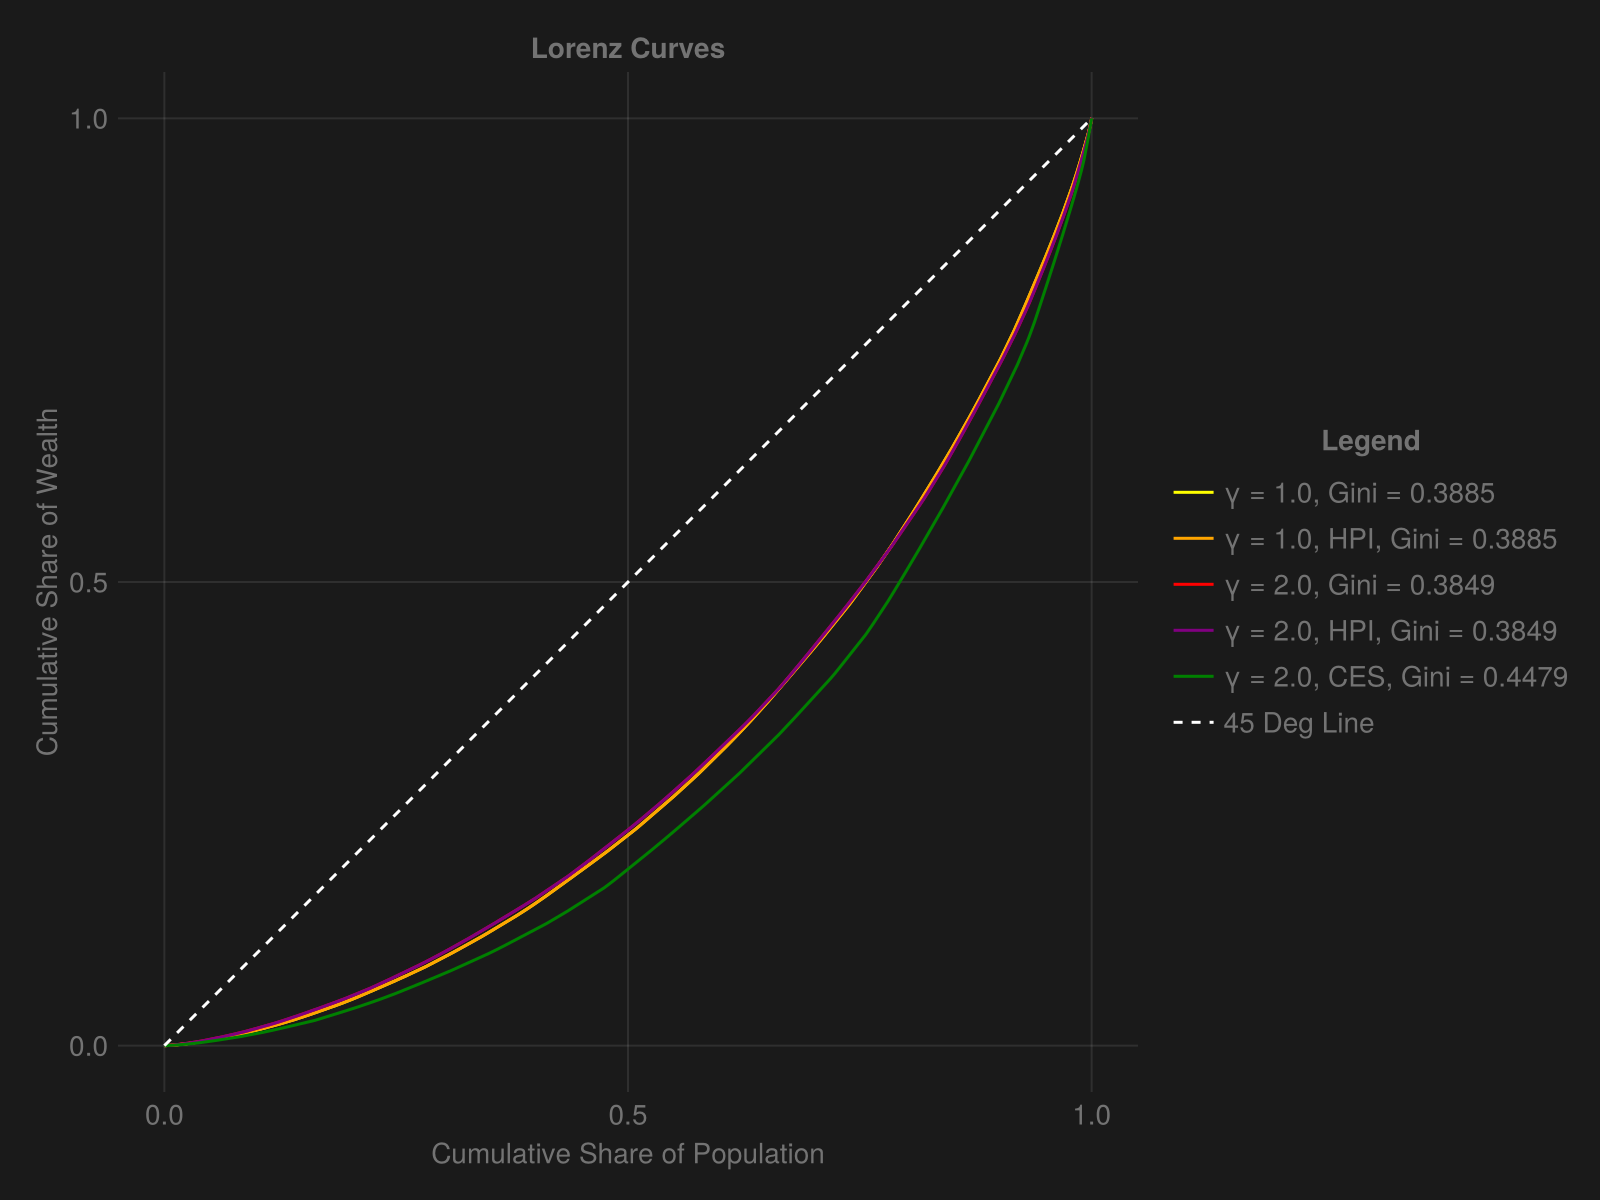

In [139]:
function gini_coeff(distribution, wealth, pars)
    (; na, nz) = pars
    n = na * nz
    gini_w = zeros(n)
    gini_dist = zeros(n)
    lorenz = zeros(n)
    wealth = reshape(wealth, n)
    distribution = reshape(distribution, n)
    sorted_wealth = sort(wealth, rev = false)
    sorted_indices = sortperm(wealth)
    sorted_distribution = distribution[sorted_indices]
    for i in 1:n
        gini_w[i] = sorted_wealth[i] * sorted_distribution[i]
        if i == 1
            lorenz[i] = gini_w[i]
            gini_dist[i] = sorted_distribution[i]
        else
            lorenz[i] = lorenz[i-1] + gini_w[i]
            gini_dist[i] = gini_dist[i-1] + sorted_distribution[i]
        end
    end
    lorenz = lorenz / lorenz[end]
    gini_dist = gini_dist / gini_dist[end]
    area_under_lorenz = 0.0
    for i in 2:length(lorenz)
        area_under_lorenz += 0.5 * (lorenz[i] + lorenz[i-1]) * (gini_dist[i] - gini_dist[i-1])
    end
    Gini_round = 1 - 2 * area_under_lorenz
    Gini_round = round(Gini_round, digits = 4)
    return lorenz, gini_dist, Gini_round
end

l1, d1, g1 = gini_coeff(dist_vfi_crra1, wealth_vfi_crra1, pars_crra1)
l1h, d1h, g1h = gini_coeff(dist_hpi_crra1, wealth_hpi_crra1, pars_crra1)
l2, d2, g2 = gini_coeff(dist_vfi_crra2, wealth_vfi_crra2, pars_crra2)
l2h, d2h, g2h = gini_coeff(dist_hpi_crra2, wealth_hpi_crra2, pars_crra2)
l3, d3, g3 = gini_coeff(dist_vfi_ces2, wealth_vfi_ces2, pars_ces2)

fig = Figure(size = (800,600))
ax = Axis(fig[1,1], xlabel = "Cumulative Share of Population", ylabel = "Cumulative Share of Wealth", title = "Lorenz Curves")
lines!(ax, d1, l1, label = "γ = 1.0, Gini = $g1", color = :yellow)
lines!(ax, d1h, l1h, label = "γ = 1.0, HPI, Gini = $g1h", color = :orange)
lines!(ax, d2, l2, label = "γ = 2.0, Gini = $g2", color = :red)
lines!(ax, d2h, l2h, label = "γ = 2.0, HPI, Gini = $g2h", color = :purple)
lines!(ax, d3, l3, label = "γ = 2.0, CES, Gini = $g3", color = :green)
lines!(ax, d1, d1, label = "45 Deg Line", color = :white, linestyle = :dash)
legend = Legend(fig[1,2], ax, "Legend", orientation = :vertical, fontsize = 4)
fig